# Integer Multiplication using Fast Fourier Transform

This notebook is part 2 of implementing different algorithms for integer manipulation. The aim is to build code that can handle multiplication (and add/subtract) in any base, from binary through decimal to 'base 1,000,000' and above. It will also handle long integers - 10s of thousands of digits or 'limbs' long.

Part 1 an be found here: [(Integer Multiplication using Karatsuba method)]().

It turns out that multiplication using the algorithm we learned in school (shift across, multiply each digit, carry over, etc) is not the most efficient, especially when dealing with very large integers - such as those used in cryptography.

Optimising the 'big-O' complexity has seen a lot of research and small improvements big by bit, finally reaching an optimal(?) version in 2019, even if that solution (currently) only works for unusably large numbers:
- **1960: Karatsuba** -> $\mathcal{O}(n^{1.58})$ -> Faster than 'school' multiplication when $n$ is $2^{320}$ or $\sim10^{96}$
- **1963: Toom-Cook-Knuth** -> $\mathcal{O}(n⋅2^{\sqrt{2 \log n}}\log n)$ -> Generalization of Karatsuba.
- **1971: Schönhage-Strassen** -> $\mathcal{O}(n \log n \log \log n)$ -> Faster above $\sim10^{10,000}$
- **2007: Fürer** -> $\mathcal{O}(n \log n⋅2^{\mathcal{O}(log^∗ n)})$ -> Faster above $\sim10^{1,000,000,000,000,000,000}$
- **2019: Harvey & van der Hoeven** -> $\mathcal{O}(n \log n)$ -> Faster above $\sim10^{10^{38}}$ or $2^{1729^{12}}$

Harvey and van der Hoeven put forward an algorithm that achieves time $O(n \log n)$, based on a more 'extreme' use of FFT, but their formula only works for numbers with 2 raised to the 7e38 digits - which is, to say the least, impractical. But they do suggest ways of adjusting to apply to 'smaller' numbers of $2^{9^{12}}$ or $\sim10^{1,000,000,000,000}$.

Part 1 [(Integer Multiplication using Karatsuba method)]() looked at implementing the Karatsuba version. This part will look at 'Fast Fourier Transforms' and invesitigate the related 'Number Theoretic Transform', which both use the same concepts, but in different ways.

### Import the BaseBigInteger class

In [1]:
# Import the final implementation of the big integer class from Part 1:
import numpy as np
from basebiginteger import BaseBigInteger

## Fast Fourier Transform (FFT) in a nutshell...
People (myself included) spend a long time working out what FFTs do. While they have many uses, the thing we are interested in here is how they can combine and 'align' the digits of two numbers to allow a smaller number of multiplications. Instead of doing $2^{n}$ multiplications, they cut this down to $2n$. One explanation, with lots of wheels, is [given here](https://www.aimath.org/news/congruentnumbers/howtomultiply.html).

### The roots of unity
FFT works by using certain complex numbers, chosen so that they don't 'overlap' on the 'wheel'. These numbers are called the 'roots of unity' (which would make a great name for a band, by the way...). So what are 'roots of unity'?

Well, to start from a very simple formula, the 2nd root of unity is any number where $z^{2} = 1$. Hmmm, you're thinking. That is $1$... Well, yes, one is a root of unity, but not useful for us, as it 'overlaps' with the value of one itself. There are other, as we will see.

Let's try another example - the 4th root of unity is any number where $x^{4} = 1$, but also - importantly - all the lower powers of $x$ do _not_ equal $1$ and so they do not 'overlap'. That is, we also need $z^{2} \neq 1$ and $z^{3} \neq 1$. Here's where it gets 'complex'... Consider the complex number $i = \sqrt{-1}$. $i^{2} = -1$, by definition, and $z^{3} = - i$ - and we have something that doesn't overlap!

Now we can take 4 items and 'combine' them without overlapping, do the multiplication on the smaller set of numbers, then 'reverse' out after multiplying. In general, we can define a complex number that gives us the n-th root of unity. Complex numbers are often written as an exponential, and that's what I will use here (and in the implementation).

For $k = 0, 1, 2,..., n - 1$, each root is given by $e^{{{2 \pi k} \over {n}} i}$

Or, $\omega = e^{{{2 \pi} \over {n}} i}$ and the roots are $1, \omega, \omega^{2}, \omega^{2}, ..., \omega^{n-1}$.

The complex parts are only there for the combining. Once the process is complete, we lose the complex part and come back to reality (and our number multiplied).

Now here's the implementation:

In [3]:
#Algorithm
class FFT:
    omega_cache = {}
    def do_FFT(self, signal, direction):
        """Input: An n-length coefficient vector signal = [a_0,a_1,...,a_(n-1)]
        and a primitive nth root of unity omega (n = a power of 2)
        Output: A vector y of values of the polynomial for signal
        at the nth roots of unity."""
    
        def omega(p, q, direction=1):
            # Cache the answers - saves time
            if (p,q,direction) not in FFT.omega_cache:
                FFT.omega_cache[(p,q,direction)] = np.exp((direction * 2.0 * np.pi * 1j * q) / p)
             
            return FFT.omega_cache[(p,q,direction)]

        n = len(signal)
        if n == 1:
            return signal

        # Divide step
        signal_even = self.do_FFT(signal[0:n:2], direction)
        signal_odd = self.do_FFT(signal[1:n:2], direction)

        combined = np.zeros(n, dtype=complex)
        for m in range(n//2):
            combined[m] = signal_even[m] + omega(n, -m, direction) * signal_odd[m]
            combined[m + n//2] = signal_even[m] - omega(n, -m, direction) * signal_odd[m]

        return combined

    def FFT(self, signal):
        return self.do_FFT(signal, 1)

    def IFFT(self, signal):
        return self.do_FFT(signal, -1).real.round().astype(np.int64) // len(signal)
    
def getFFTimp():
    return FFT()

class npFFT (FFT):
    def do_FFT(self, signal, direction):
        pass

    def FFT(self, signal):
        return np.fft.fft(signal)

    def IFFT(self, signal):
        return np.fft.ifft(signal)


In [4]:
# Test the algorithm for 9999 x 9999999 - first pass:
FFTimp = FFT()
npFFTimp = npFFT()

a = np.asarray([ 9,  9,  0,  0,  0,  0,  0,  0])
FA = FFTimp.FFT(a)
FAnp = npFFTimp.FFT(a)
#print (FA, FAnp)

b = np.asarray([ 9,  9,  9,  9,  9,  9,  9,  0])
FB = FFTimp.FFT (b)
FBnp = npFFTimp.FFT(b)
#print (FB, FBnp)

FMULT = np.multiply(FA, FB)
FMULTnp = np.multiply(FAnp, FBnp)
#print (FMULT, FMULTnp)

mult = FFTimp.IFFT(FMULT)
mult = mult.real.round().astype(np.int64)
print('Using the FFT() implementation: ', mult)

multnp = npFFTimp.IFFT(FMULTnp).real.round().astype(np.int64) # round to avoid precision cutoff errors
print ('Using the NumPy implementation: ', multnp)

Using the FFT() implementation:  [ 81 162 162 162 162 162 162  81]
Using the NumPy implementation:  [ 81 162 162 162 162 162 162  81]


So far, so good. This implementation matches the numpy result. Next, here's the multiplication function, which draws on various implementations of the Cooley–Tukey Fast Fourier Transform (FFT) algorithm.

In [55]:
def fft_mult(a, b, FFTimp=getFFTimp()):
    length_a = len(a._number)
    length_b = len(b._number)

    n = 2
    while (length_b  > n):
        n <<= 1

    length_chunk = n - length_b + 1

    a_base = a.shift(length_b - 1)
    steps = 1
    if length_chunk:
        steps = (length_a) // length_chunk
        if (length_a) % length_chunk: steps += 1
    if not steps:
        steps = 1

    a_array = np.zeros((steps, n))
    for i in range(steps):
        # The next chunk
        for j in range (0, length_chunk):
            # Add in the chunk, remembering that _number is reversed
            a_array[i,j] = a_base._number[-j-length_chunk*i-1]

    b_base = b.shift(n-len(b._number))

    FBnp = FFTimp.FFT(np.flip(b_base._number))

    yres = np.zeros(n + length_chunk * steps, dtype=complex)

    for i in range(steps):
        yres[i*length_chunk:i*length_chunk+n] += FFTimp.IFFT(np.multiply(FBnp, FFTimp.FFT(a_array[i])))

    return BaseBigInteger(yres.real.round().astype(np.int64)[length_a + length_b - 2::-1], base=a._base, store=np.int64)


### A quick test

In [6]:
#num1 = num2 = 987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432
num1 = num2 = 99911100641
#num2 = 999
a = BaseBigInteger(num1)
b = BaseBigInteger(num2)
print('Python:   ', num1 * num2)
print('Karatsuba:', a*b)
print('FFT:      ', fft_mult(a,b))
print('FFT:      ', fft_mult(a,b,npFFT()))


Python:    9982228031296030610881
Karatsuba: 9982228031296030610881
FFT:       9982228031296030610881
FFT:       9982228031296030610881


In [57]:
num1 = '9'*100
num2 = '123'*(99//3)
a = BaseBigInteger(num1)
b = BaseBigInteger(num2)
c = BaseBigInteger(num1, base=1000000, store=np.int64)
d = BaseBigInteger(num2, base=1000000, store=np.int64)


In [58]:
print ('Number Length:', len(a._number))
print('Python')
%timeit  (int(num1) * int(num2))
#print('Karatsuba - base 10')
#%timeit (a*b)
print('Karatsuba - base 1000000')
%timeit (c*d)
print ('FFT')
%timeit fft_mult(a,b)
print ('FFT - np')
%timeit fft_mult(a,b, npFFT())

print ('FFT - base 1000000')
%timeit fft_mult(c,d)
print ('FFT - np - base 1000000')
%timeit fft_mult(c,d, npFFT())


Number Length: 100
Python
1.16 µs ± 17.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
Karatsuba - base 1000000
94.3 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FFT
16.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
FFT - np
1.63 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
FFT - base 1000000
15 ms ± 603 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FFT - np - base 1000000
638 µs ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
import numpy as np

# Reimplement the class
class FFTBaseInteger (BaseBigInteger):
    
    def __init__ (self, x, base=10, negative=False, store=np.int16):
        FFTimp=getFFTimp()
        super().__init__(x,base,negative,store)

    def _multiply_numbers(self, first, second):
        length_first = len(first)
        length_second = len(second)

        n = 2
        while (length_second  > n):
            n <<= 1

        length_chunk = n - length_second + 1

        first_base = np.append(np.zeros(length_second - 1, dtype=self._store),first)

        steps = 1
        if length_chunk:
            steps = (length_first) // length_chunk
            if (length_first) % length_chunk: steps += 1
        if not steps:
            steps = 1

        first_array = np.zeros((steps, n))
        for i in range(steps):
            # The next chunk
            for j in range (0, length_chunk):
                # Add in the chunk, remembering that _number is reversed
                first_array[i,j] = first_base[-j-length_chunk*i-1]

        second_base = np.append(np.zeros(n-length_second, dtype=self._store),second)

        Fsecondnp = FFTimp.FFT(np.flip(second_base))

        yres = np.zeros(n + length_chunk * steps, dtype=complex)

        for i in range(steps):
            yres[i*length_chunk:i*length_chunk+n] += FFTimp.IFFT(np.multiply(Fsecondnp, FFTimp.FFT(first_array[i])))

        return yres.real.round().astype(np.int64)[length_first + length_second - 2::-1], False


In [11]:
num1 = num2 = 9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999
a = BaseBigInteger(num1)
b = BaseBigInteger(num2)
print (a*b)

x = FFTBaseInteger(num1)
y = FFTBaseInteger(num2)
print (x*y)

99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999980000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999980000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001


In [12]:
def get_base_integer(digits, base=10, store=np.int16):
    return BaseBigInteger(digits, base, negative=False, store=store)

# Generate numbers with 50, 100, 150, 200, 250 and 300 digits
def do_speed_test(step, top, check_products=False, base=100, title=''):
    if len(title):
        print(title)
        print(len(title)*'=')
    store = np.int16
    if base > 100:
        store = np.int64

    results = []
    num_dig_base = 0
    b = base
    while (b > 1):
        num_dig_base += 1
        b //= 10
    for num_digits in range (step, top+step, step):
        print(f'Number Length: {num_digits}')
        # Create a set of random digits of the required length:
        digits = np.random.randint(0,9,num_digits)
        py_num = 0

        # The BaseInteger class can initialise from an np_array, as it uses these
        # internally. But they are stored 'big endian' (lowest digit first).
        big_base_digits = []
        if base > 10:
            for slice in range(0,len(digits)-num_dig_base,num_dig_base):
                temp_num = 0
                for x in range(num_dig_base):
                    temp_num *= 10 # Shift up one place
                    temp_num += int(digits[slice+x]) # Add the next digit
                big_base_digits.append(temp_num)
        else:
            big_base_digits = digits

        # print(big_base_digits)
        bi_num = get_base_integer(np.asarray(big_base_digits,dtype=store), base, store)
        
        # Turn these into a python integer, and we do this 'little endian':
        py_num = int(str(bi_num))
        #print("> Test number:", py_num)

        # Check we have the same numbers. Note the casts to get an integer.
        if py_num - int(str(bi_num)) != 0:
            print("> Error - numbers are different.")

        # Use the timeit magic and note the result
        py_result = %timeit -n10 -o (py_num*py_num)
        bi_result = %timeit -n1 -r1 -o (bi_num * get_base_integer(digits))
        if check_products:
            if py_num*py_num - int(str(bi_num * get_base_integer(digits))) != 0:
                print("> Error - products are different.")
                print(py_num*py_num)
                print(bi_num * get_base_integer(np.asarray(big_base_digits,dtype=store), base))
            else:
                print("> OK: products match.")

        # Print out the difference in speed and store in our results array.
        print(f'Number Length {num_digits}: Python is {bi_result.best/py_result.best:,.0f} times faster.\n')
        results.append(bi_result.best/py_result.best)
    return results

In [13]:
step = 50
top = 600
def get_base_integer(digits, base=10, store=np.int16):
    return BaseBigInteger(digits, base, False, store) # USING KARATSUBA

results_karatsuba = do_speed_test(step, top, False, 10, title ='Karatsuba')

def getFFTimp():
    return npFFT()
def get_base_integer(digits, base=10, store=np.int16):
    return FFTBaseInteger(digits, base, False, store)
results_fft = do_speed_test(step, top, False, 10, title ='FFT with np')

Karatsuba
Number Length: 50
183 ns ± 44 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 355,046 times faster.

Number Length: 100
279 ns ± 29.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
136 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 523,026 times faster.

Number Length: 150
413 ns ± 39.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
275 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 706,081 times faster.

Number Length: 200
566 ns ± 38.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
409 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 743,237 times faster.

Number Length: 250
729 ns ± 38 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
579 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250: Pyt

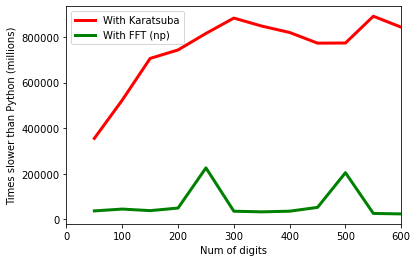

In [14]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.plot(range (step, top+step, step), results_fft, color='green', linewidth=3, label='With FFT (np)')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python')
plt.legend()
plt.show()

In [15]:
step = 50
top = 600
def get_base_integer(digits, base=1000000, store=np.int64):
    return BaseBigInteger(digits, base, False, store)

results_karatsuba_million = do_speed_test(step, top, False, 1000000, title='Karatsuba - base 1,000,000')

def getFFTimp():
    return npFFT()
def get_base_integer(digits, base=1000000, store=np.int16):
    return FFTBaseInteger(digits, base, False, store)
results_fft_million = do_speed_test(step, top, False, 1000000, title='FFT with np - base 1,000,000')

Karatsuba - base 1,000,000
Number Length: 50
181 ns ± 32.3 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 118,252 times faster.

Number Length: 100
283 ns ± 48 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 165,050 times faster.

Number Length: 150
376 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 215,251 times faster.

Number Length: 200
554 ns ± 51.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
138 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 200: Python is 259,558 times faster.

Number Length: 250
777 ns ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
183 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
N

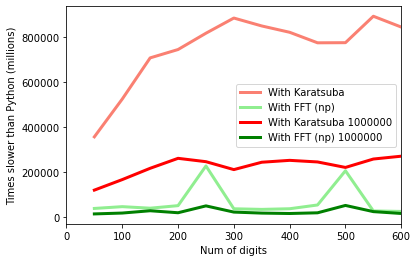

In [16]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_karatsuba, color='salmon', linewidth=3, label='With Karatsuba')
plt.plot(range (step, top+step, step), results_fft, color='lightgreen', linewidth=3, label='With FFT (np)')
plt.plot(range (step, top+step, step), results_karatsuba_million, color='red', linewidth=3, label='With Karatsuba 1000000')
plt.plot(range (step, top+step, step), results_fft_million, color='green', linewidth=3, label='With FFT (np) 1000000')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python')
plt.legend()
plt.show()

## Next step
So, using the FFT implementation from numpy works a little closer to the Python speeds - around 20,000 times slower now - and better than the Karatsuba implementation. This is probably due to spending more time in optimised code, instead of Python code, and Karatsuba would probably still be faster in C.

Let's try some larger numbers - up to 10,000 digits.

In [17]:
step = 1000
top = 10000
def get_base_integer(digits, base=1000000, store=np.int16):
    return BaseBigInteger(digits, base, False, store)

results_karatsuba_million = do_speed_test(step, top, False, 1000000, title='Karatsuba - base 1,000,000')

Karatsuba - base 1,000,000
Number Length: 1000
10.9 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 1000: Python is 134,412 times faster.

Number Length: 2000
23.7 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 2000: Python is 162,958 times faster.

Number Length: 3000
48.3 µs ± 5.74 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 3000: Python is 219,567 times faster.

Number Length: 4000
84.4 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 4000: Python is 165,166 times faster.

Number Length: 5000
111 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 l

In [41]:

def getFFTimp():
    return npFFT()
def get_base_integer(digits, base=1000000, store=np.int16):
    return FFTBaseInteger(digits, base, False, store)
results_fft_million = do_speed_test(step, top, False, 1000000, title='FFT with np - base 1,000,000')

FFT with np - base 1,000,000
Number Length: 1000
8.56 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
214 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 1000: Python is 25,426 times faster.

Number Length: 2000
24.9 µs ± 526 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
390 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 2000: Python is 16,126 times faster.

Number Length: 3000
42.1 µs ± 292 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
174 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 3000: Python is 4,163 times faster.

Number Length: 4000
76.3 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
850 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 4000: Python is 11,640 times faster.

Number Length: 5000
121 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
387 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

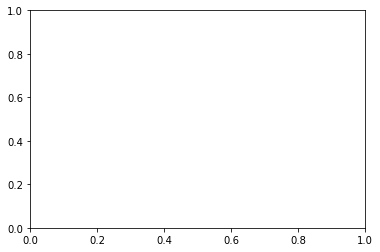

In [61]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_karatsuba_million, color='red', linewidth=3, label='With Karatsuba 1000000')
plt.plot(range (step, top+step, step), results_fft_million, color='green', linewidth=3, label='With FFT (np) 1000000')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python')
plt.legend()
plt.show()

## And now 250,000 digits
This takes around a minute on my processor, and is 900 times slower than Python.

In [20]:
step = 250_000
top = 250_000
def get_base_integer(digits, base=1000000, store=np.int64):
    return BaseBigInteger(digits, base, False, store) # USING KARATSUBA

#results_karatsuba_million = do_speed_test(step, top, False, 1000000)

def getFFTimp():
    return npFFT()
def get_base_integer(digits, base=1000000, store=np.int64):
    return FFTBaseInteger(digits,base, False, store) # USING KARATSUBA 1000000
do_speed_test(step, top, False, 1000000, title='FFT with np - base 1,000,000 - 250,000 digits')

FFT with np - base 1,000,000 - 250,000 digits
Number Length: 250000
73.1 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250000: Python is 910 times faster.



## Number Theoretic Transform (NTT)
Now let's turn to the NTT, using modular arithmatic and 'rings'.

This inherits from the FFT class, but overrides the transform, so that it can be substituted for the FFT implementation in the integer class. It's set up to use (mod 769) arithmatic, but allows this to be specified when the class is instantiated, and we will try out (mod 3329) and (mod 8380417) - both of which are using in cryptography. We need to choose these carefully, and ones that have the roots that we need.

After some experimentation and incremental improvements, I decided to cache the values of the powers of omega (the roots of unity that we use). Similarly, I find all the roots (for 2nd, 4th, 6th,...,$2^{n}$th). The rest of the implementation is very much like for FFT.

BIG NOTE: This uses modular inverse ```pow(num,-1,mod)``` which is only implemented from Python 3.8 onwards.

In [21]:
#Algorithm
class NFFT(FFT):
    def __init__(self, modulo=769):
        # Seed the primitive root cache
        self.modulo = modulo
        self.omega_cache = {}
        self.root_cache = {}
        n = 512
        while n > 1:
            if n*2 in self.root_cache:
                self.root_cache[n] = pow(self.root_cache[n*2], 2, modulo)
            else:
                self.get_primitive_root(n)
            n //= 2        

    def get_primitive_root(self, n):
        if n not in self.root_cache:
            primitive_root = 0
            for z in range(2, self.modulo):
                for x in range (1, n+1):
                    if pow(z,x,self.modulo) == 1:
                        if (x == n):
                            primitive_root = z
                            break
                        else:
                            break
                if primitive_root:
                    break
            if not primitive_root:
                return
            self.root_cache[n] = primitive_root
        return self.root_cache[n]

    def do_FFT(self, signal, direction):
        """Input: An n-length coefficient vector signal = [a_0,a_1,...,a_(n-1)]
        and a primitive nth root of unity omega (n = a power of 2)
        Output: A vector y of values of the polynomial for signal
        at the nth roots of unity."""
    
        def omega(root, power):
            # Cache the answers - saves time
            if (root, power) not in self.omega_cache:
                self.omega_cache[(root, power)] = pow(root, power, self.modulo)
             
            return self.omega_cache[(root, power)]
        

        n = len(signal)
        if n == 1:
            return signal
        
        # Divide step
        signal_even = self.do_FFT(signal[0:n:2], direction)
        signal_odd = self.do_FFT(signal[1:n:2], direction)

        primitive_root = self.get_primitive_root(n)

        combined = np.zeros(n, dtype=np.int64)
        for m in range(n//2):
            power = 2 * n * m * direction
            combined[m] = signal_even[m] + omega(primitive_root, power) * signal_odd[m]
            combined[m + n//2] = signal_even[m] - omega(primitive_root, power) * signal_odd[m]
        
        np.remainder(combined, self.modulo, out=combined)

        return combined

    def FFT(self, signal):
        return self.do_FFT(signal, 1)

    def IFFT(self, signal):

        result = self.do_FFT(signal, -1) * pow(len(signal), -1, self.modulo)
        return np.remainder(result, self.modulo)
    


In [22]:
# Set up a series of different moduli:
nfft769 = NFFT(769)
nfft3329 = NFFT(3329) # This one takes the longest to find roots
nfft8380417 = NFFT(8380417)

In [23]:
# Test transform and inverse - should get us back to the start on each:
print(nfft769.IFFT(nfft769.FFT([15, 21, 13, 44])))
print(nfft769.IFFT(nfft769.FFT([153, 321, 133, 44])))
print(nfft3329.IFFT(nfft3329.FFT([15, 21, 13, 44])))
print(nfft3329.IFFT(nfft3329.FFT([153, 321, 133, 44])))
print(nfft8380417.IFFT(nfft8380417.FFT([15, 21, 13, 44])))
print(nfft8380417.IFFT(nfft8380417.FFT([153, 321, 133, 44])))

[15 21 13 44]
[153 321 133  44]
[15 21 13 44]
[153 321 133  44]
[15 21 13 44]
[153 321 133  44]


In [24]:
num1 = 99999999999999999999999999999
num2 = 15464199154641991546419915464199
a = BaseBigInteger(num1)
b = BaseBigInteger(num2)
#c = BaseBigInteger(num1, base=1000000)
#d = BaseBigInteger(num2, base=1000000)

print ('FFT')
print (a, 'x', b)
print (fft_mult(a,b, nfft8380417))
print (a*b)

FFT
99999999999999999999999999999 x 15464199154641991546419915464199
1546419915464199154641991546404435800845358008453580084535801
1546419915464199154641991546404435800845358008453580084535801


In [25]:
print (nfft769.modulo, nfft769.root_cache)
print (nfft3329.modulo, nfft3329.root_cache)
print (nfft8380417.modulo, nfft8380417.root_cache)

769 {256: 7, 128: 49, 64: 94, 32: 377, 16: 633, 8: 40, 4: 62, 2: 768}
3329 {256: 17, 128: 289, 64: 296, 32: 1062, 16: 2642, 8: 2580, 4: 1729, 2: 3328}
8380417 {512: 1753, 256: 3073009, 128: 3602218, 64: 5010068, 32: 7778734, 16: 5178923, 8: 3765607, 4: 4808194, 2: 8380416}


In [26]:
#print ('FFT')
#%timeit fft_mult(a,b)
#print ('FFT - np')
#%timeit fft_mult(a,b, npFFT())
print ('FFT2')
%timeit fft_mult(a,b, FFT())
print ('FFT2 - np')
%timeit fft_mult(a,b, npFFT())
print ('FFT2 - NTT mod 769')
%timeit fft_mult(a,b, nfft769)
print ('FFT2 - NTT mod 3329')
%timeit fft_mult(a,b, nfft3329)
print ('FFT2 - NTT mod 8380417')
%timeit fft_mult(a,b, nfft8380417)
#print ('FFT2 - base 1000000')
#%timeit fft_mult(c, d)
#print ('FFT2 - np - base 1000000')
#%timeit fft_mult(c, d, npFFT())


FFT2
15.1 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FFT2 - np
550 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
FFT2 - NTT mod 769
20.7 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FFT2 - NTT mod 3329
20.5 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FFT2 - NTT mod 8380417
19.9 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
num1 = num2 = 987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432987654329876543209876543209876543298765432987654320987654320987654329876543298765432098765432098765432
a = BaseBigInteger(num1)
b = BaseBigInteger(num2)
c = BaseBigInteger(num1, base=1000000)
d = BaseBigInteger(num2, base=1000000)

print ('FFT - nfft8380417')
print ('Number 1:', len(c._number), 'digits')
print ('Number 2:', len(d._number), 'digits')
print (fft_mult(c,d, nfft8380417))
print (num1*num2)

FFT - nfft8380417
Number 1: 204 digits
Number 2: 204 digits
8971130290851886849395592849231975545751591260112240492463667545063813235557276076829254787285667189920383073304461456211427753534099409508975723643130075116203654257543707583185825347808891901142522642402807907841865044998421035523202353408675785627107279708936548694073561238212486899092582803986434559763754140396973984253155660132030092190267152326088702112269494688108240963180805727194313489065534712253884949179018040392317227184838657879102937001611054686142488606979470840583973865644390044255104553250402702725183462384370480257827824550003487556022186294614897744516595889885230324170570597848036575127755869555727374346657033987413489658622864787521383388966347011330567864582350424525284513995816791709438316766335390954759077638160462872019225528104778007942897950253855688482791119610972343872511911988735875073526827245627449924295769116523751054440129203087260158737280936555234618377052567302585981615036174483578702865759

In [62]:
import sympy
# try sympy.ntt and sympy.innt
# and also

# sequence 
seq = [153, 321, 133, 44, ]
  
# Prime modulus of the form (m * 2**k + 1)
prime_no = 3 * 2**8 + 1
  
# ntt
transform = sympy.ntt(seq, prime_no)
print ("NTT : ", transform)


NTT :  [651, 276, 690, 533]


In [30]:
import operator
def test_base_operator(x, y, op_name, op_func, base):
    print(f'Python {op_name}  {np.base_repr(op_func(int(x, base),int(y, base)), base)}')
    def getFFTimp():
        return FFT()
    print(f'FFT {op_name}     {op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base))}')
    def getFFTimp():
        return npFFT()
    print(f'FFT(np) {op_name} {op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base))}')
    def getFFTimp():
        return nfft8380417
    print(f'NFFT {op_name}    {op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base))}')

def test_base_integer_bases_operators(base, num1, num2):
    print(f'Base {base}')
    print('='*(5+len(str(base))))
    print('Num 1:   ', num1)
    print('Num 2:   ', num2)
    test_base_operator(num1, num2,'+', operator.add, base)
    test_base_operator(num1, num2,'-', operator.sub, base)
    test_base_operator(num1, num2,'x', operator.mul, base)

test_base_integer_bases_operators(2, num1 = '101001010010111011100111001', num2 = '11110111011100000101110111101')
test_base_integer_bases_operators(8, num1 = '235356344561234346451230', num2 = '503453545231356344034')
test_base_integer_bases_operators(16, num1 = 'BADF00DFEEDFEDDEAD', num2 = 'C0FFEEEEEEEEEEEEEEEEEE')
test_base_integer_bases_operators(36, num1 = '9876543210qwertyuiopasdfghjklzxcvbnm', num2 = 'thequickbrownfoxjumpsoverthelazydog')


Base 2
Num 1:    101001010010111011100111001
Num 2:    11110111011100000101110111101
Python +  100100000101111000001011110110
FFT +     100100000101111000001011110110
FFT(np) + 100100000101111000001011110110
NFFT +    100100000101111000001011110110
Python -  -11001110001001001010010000100
FFT -     -11001110001001001010010000100
FFT(np) - -11001110001001001010010000100
NFFT -    -11001110001001001010010000100
Python x  10011111101010001100001000011100101110100111100000010101
FFT x     10011111101010001100001000011100101110100111100000010101
FFT(np) x 10011111101010001100001000011100101110100111100000010101
NFFT x    10011111101010001100001000011100101110100111100000010101
Base 8
Num 1:    235356344561234346451230
Num 2:    503453545231356344034
Python +  236062020326465725015264
FFT +     236062020326465725015264
FFT(np) + 236062020326465725015264
NFFT +    236062020326465725015264
Python -  234652671014002770105174
FFT -     234652671014002770105174
FFT(np) - 234652671014002770105174


In [31]:
import operator
def test_base_operator_speeds(x, y, op_name, op_func, base):
    print(f'Python {op_name} ',end=' ')
    %timeit (np.base_repr(op_func(int(x, base),int(y, base)), base))
    def getFFTimp():
        return FFT()
    print(f'FFT {op_name}   ',end=' ')
    %timeit (op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base)))
    def getFFTimp():
        return npFFT()
    print(f'FFT(np) {op_name}',end=' ')
    %timeit (op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base)))
    def getFFTimp():
        return nfft8380417
    print(f'NFFT {op_name}',end=' ')
    %timeit (op_func(FFTBaseInteger(x, base=base), FFTBaseInteger(y, base=base)))

def test_base_integer_bases_mult_speed(base, num1, num2):
    print(f'Base {base}')
    print('='*(5+len(str(base))))
    print('Num 1:   ', num1)
    print('Num 2:   ', num2)
    test_base_operator_speeds(num1, num2,'+', operator.add, base)
    test_base_operator_speeds(num1, num2,'-', operator.sub, base)
    test_base_operator_speeds(num1, num2,'x', operator.mul, base)

test_base_integer_bases_mult_speed(2, num1 = '101001010010111011100111001', num2 = '11110111011100000101110111101')
test_base_integer_bases_mult_speed(8, num1 = '235356344561234346451230', num2 = '503453545231356344034')
test_base_integer_bases_mult_speed(16, num1 = 'BADF00DFEEDFEDDEAD', num2 = 'FFFFFFFFFFFFFFFFFFFFFFF')
test_base_integer_bases_mult_speed(36, num1 = '9876543210qwertyuiopasdfghjklzxcvbnm', num2 = 'abcdefghijklmnopqrstuvwxyz1234567890')


Base 2
Num 1:    101001010010111011100111001
Num 2:    11110111011100000101110111101
Python +  6.45 µs ± 155 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
FFT +    606 µs ± 6.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
FFT(np) + 637 µs ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NFFT + 620 µs ± 34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Python -  6.51 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
FFT -    780 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
FFT(np) - 724 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NFFT - 716 µs ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Python x  15.8 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
FFT x    4.9 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
FFT(np) x 4.29 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
NFFT x 4.25 ms ± 380

In [44]:
step = 1000
top = 10000
def getFFTimp():
    return nfft8380417
def get_base_integer(digits, base=10, store=np.int16):
    return FFTBaseInteger(digits, base, False, store)
results_nfft8380417 = do_speed_test(step, top, True, 10, title='NTT (8380417)')

NTT (8380417)
Number Length: 1000
11.1 µs ± 851 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> OK: products match.
Number Length 1000: Python is 100,543 times faster.

Number Length: 2000
24.4 µs ± 614 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> OK: products match.
Number Length 2000: Python is 91,052 times faster.

Number Length: 3000
45.9 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
429 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> OK: products match.
Number Length 3000: Python is 10,217 times faster.

Number Length: 4000
83.5 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.88 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> OK: products match.
Number Length 4000: Python is 68,183 times faster.

Number Length: 5000
115 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs,

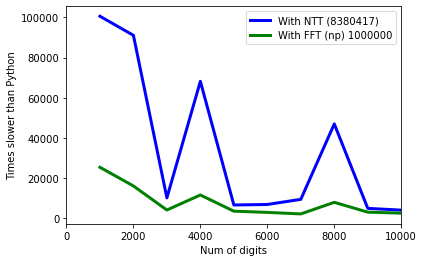

In [45]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_nfft8380417, color='blue', linewidth=3, label='With NTT (8380417)')
plt.plot(range (step, top+step, step), results_fft_million, color='green', linewidth=3, label='With FFT (np) 1000000')
plt.xlim(0, top)
plt.xlabel('Num of digits')
plt.ylabel('Times slower than Python')
plt.legend()
plt.show()

### Comments and Summary
An NTT algorithm gives good results, although there seem to be some lengths where the algorithm is slower. These appear to be around the powers of 2 and the FFT also shows a slower speed in these areas - although less pronounced.

Note that the FFT uses floating point implementation and complex numbers, and the code how has used the efficient implementation of that. NTT uses modular arithmatic. It may become more efficient, given the right implementation, asymptopically for extremely large numbers.

In [ ]:
# Print out the powers of two.
for N in range(0,10000):
    if N & (N - 1) == 0:
        print (N, "is a power of 2")

In [47]:
step = 250_000
top = 250_000
def getFFTimp():
    return nfft8380417
def get_base_integer(digits, base=10, store=np.int64):
    return FFTBaseInteger(digits,base, False, store) # Base 10000000 gives an error
do_speed_test(step, top, True, 10, title='NFFT (8380417) - 250,000 digits')

NFFT (8380417) - 250,000 digits
Number Length: 250000
57 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
> OK: products match.
Number Length 250000: Python is 4,036 times faster.



[4035.97262409396]